# Comprehensive Analysis of B5T with Firestore Data
This notebook covers the extraction and analysis of B5T-related data from Firestore, including comparisons of average ratings and visualization using tag clouds.

In [1]:
import firebase_admin
from firebase_admin import credentials, firestore
import pandas as pd
from collections import defaultdict

import statsmodels.api as sm
import statsmodels
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols


# Setup Firebase connection
cred = credentials.Certificate('savoir-faire-cef81-firebase-adminsdk-8zbn3-c128c666c9.json')
firebase_admin.initialize_app(cred)
db = firestore.client()

## Data Munging!
1. Calculate both overall average ratings and average matching ratings for each individual document in the Firestore collection.
2. Provide a grouped summary to show these averages for each CurrentPromptB5T category across all records.

In [2]:
def fetch_and_process_data(database, collection_name: str) -> dict[str, list]:
    collection_ref = database.collection(collection_name)
    docs = collection_ref.stream()

    rating_dict = defaultdict(list)
    for doc in docs:
        doc_data = doc.to_dict()
        currentPromptB5T: str = doc_data.get('currentPromptB5T', '')
        responses: str = doc_data.get('responses', {})

        for response in responses.values():
            rating = response.get('rating', '')
            b5t = response.get('B5T', '')
            rating_dict['doc_id'].append(doc.id)
            rating_dict['current_prompt_b5t'].append(currentPromptB5T)
            rating_dict['current_item_b5t'].append(b5t)

            rating_dict['rating'].append(rating)
    rating_dict = pd.DataFrame(rating_dict)
    rating_df = rating_dict.sort_values(['current_prompt_b5t',
                                           'doc_id',
                                           'current_item_b5t'])
    return rating_df

In [8]:
data = fetch_and_process_data(database=db,
                               collection_name='StaticExpressions')

In [10]:
data.to_csv('survey_data.csv', index=False)

# Analysis and Reporting
With the data structured to include detailed ratings for each document, we'll analyze it using pandas and generate aggregated summaries

In [11]:
data = pd.read_csv('survey_data.csv')

In [12]:
data['matching'] = (data['current_prompt_b5t'] == data['current_item_b5t']).astype(str)
data.head(5)

,doc_id,current_prompt_b5t,current_item_b5t,rating,matching
0,5lRokilG4H2o99TYozDI,Agreeableness,Agreeableness,3,True
1,5lRokilG4H2o99TYozDI,Agreeableness,Agreeableness,4,True
2,5lRokilG4H2o99TYozDI,Agreeableness,Conscientiousness,2,False
3,5lRokilG4H2o99TYozDI,Agreeableness,Conscientiousness,3,False
4,5lRokilG4H2o99TYozDI,Agreeableness,Emotional Stability,2,False


In [13]:
data.groupby('matching')['rating'].agg(['count','mean', 'median', 'std'])

,count,mean,median,std
matching,,,,
False,328,3.341463,3.0,1.193453
True,82,3.658537,4.0,1.188624


In [14]:
data.groupby('current_prompt_b5t')['rating'].agg(['count','mean', 'median', 'std'])

,count,mean,median,std
current_prompt_b5t,,,,
Agreeableness,80,3.675000,4.0,0.964890
Conscientiousness,80,3.100000,3.0,1.346350
Emotional Stability,80,3.600000,4.0,0.975653
Extraversion,90,3.611111,4.0,1.098461
Openness,80,3.012500,3.0,1.400667


In [15]:
data_split = data.pivot_table(index=['doc_id', 'current_prompt_b5t'], columns='matching', values='rating').reset_index()
data_split.columns = ['doc_id', 'current_prompt_b5t', 'unmatched', 'matched']

In [16]:
data_split.sort_values('current_prompt_b5t').head()

,doc_id,current_prompt_b5t,unmatched,matched
38,vlKhBC02kj7NGqdpfG1A,Agreeableness,2.875,3.0
2,5lRokilG4H2o99TYozDI,Agreeableness,3.250,3.5
19,TnZiD0BYvEkdSiGOXH8q,Agreeableness,3.625,4.5
37,u0cwPh2ThkPcdQi5pISw,Agreeableness,3.125,3.0
31,jbiaKuoJkC6BX8FK1zPM,Agreeableness,3.875,3.5


In [17]:
data_split[['matched', 'unmatched']].mean()

matched      3.658537
unmatched    3.341463
dtype: float64

In [18]:
data.head()

,doc_id,current_prompt_b5t,current_item_b5t,rating,matching
0,5lRokilG4H2o99TYozDI,Agreeableness,Agreeableness,3,True
1,5lRokilG4H2o99TYozDI,Agreeableness,Agreeableness,4,True
2,5lRokilG4H2o99TYozDI,Agreeableness,Conscientiousness,2,False
3,5lRokilG4H2o99TYozDI,Agreeableness,Conscientiousness,3,False
4,5lRokilG4H2o99TYozDI,Agreeableness,Emotional Stability,2,False


In [19]:
data.groupby(['current_prompt_b5t', 'matching']).size().unstack(level=1)

matching,False,True
current_prompt_b5t,,
Agreeableness,64,16
Conscientiousness,64,16
Emotional Stability,64,16
Extraversion,72,18
Openness,64,16


In [20]:
pd.options.plotting.backend = "plotly"

fig = data_split.plot.scatter(x='unmatched', y='matched', symbol='current_prompt_b5t', color='current_prompt_b5t', width=800, height=500, trendline="ols", trendline_scope="overall")
fig.update_traces(marker_size=8)
fig.show()

In [21]:
data.groupby(['current_prompt_b5t','matching'])['rating'].describe()

count      mean       std  min  25%  50%   75%  \
current_prompt_b5t  matching                                                   
Agreeableness       False      64.0  3.593750  0.954833  2.0  3.0  4.0  4.00   
                    True       16.0  4.000000  0.966092  2.0  3.0  4.0  5.00   
Conscientiousness   False      64.0  3.062500  1.331844  1.0  2.0  3.0  4.00   
                    True       16.0  3.250000  1.437591  1.0  2.0  3.5  4.25   
Emotional Stability False      64.0  3.546875  0.990906  2.0  3.0  4.0  4.00   
                    True       16.0  3.812500  0.910586  2.0  3.0  4.0  4.25   
Extraversion        False      72.0  3.625000  1.093354  1.0  3.0  4.0  4.25   
                    True       18.0  3.555556  1.149026  2.0  3.0  3.5  4.75   
Openness            False      64.0  2.843750  1.359490  1.0  2.0  3.0  4.00   
                    True       16.0  3.687500  1.400893  1.0  3.5  4.0  5.00   

                              max  
current_prompt_b5t  matching       
Agreeableness       False     5.0  
                    True      5.0  
Conscientiousness   False     5.0  
                    True      5.0  
Emotional Stability False     5.0  
                    True      5.0  
Extraversion        False     5.0  
                    True      5.0  
Openness            False     5.0  
                    True      5.0

In [22]:
x1 = data_split['matched']
x2 = data_split['unmatched']
tstat, pvalue, df = statsmodels.stats.weightstats.ttest_ind(x1, x2, alternative='larger', usevar='pooled')
print('t-stat:', round(tstat, 2))
print('p-value', round(pvalue,2))
print('DF:', int(df))

t-stat: 1.58
p-value 0.06
DF: 80


In [24]:
func = lambda group: statsmodels.stats.weightstats.ttest_ind(group['matched'], group['unmatched'], alternative='larger', usevar='unequal')
group_t_stats = pd.DataFrame(data_split.groupby('current_prompt_b5t').apply(func,include_groups=True))
group_t_stats['t_stat'], group_t_stats['p_value'], group_t_stats['DF'] = zip(*group_t_stats[0])
group_t_stats.drop(columns=0, inplace=True)
group_t_stats
group_stats = pd.concat([group_stats, group_t_stats], axis=1)
pd.Series([tstat, pvalue, df])
group_stats.round(2)

/var/folders/k9/djh0448937n91n9bgglccsb40000gn/T/ipykernel_50054/3946323891.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,"(matched, mean)","(matched, std)","(unmatched, mean)","(unmatched, std)",t_stat,p_value,DF
current_prompt_b5t,,,,,,,
Agreeableness,4.00,0.85,3.59,0.51,1.16,0.13,11.53
Conscientiousness,3.25,1.34,3.06,0.94,0.32,0.38,12.58
Emotional Stability,3.81,0.59,3.55,0.48,0.99,0.17,13.38
Extraversion,3.56,0.98,3.62,0.78,-0.17,0.56,15.22
Openness,3.69,1.07,2.84,1.15,1.52,0.07,13.93


In [25]:
m= ols('matched ~ unmatched + C(current_prompt_b5t)', data=data_split).fit()
anova_lm(m)
# m.summary()

,df,sum_sq,mean_sq,F,PR(>F)
C(current_prompt_b5t),4.0,2.559790,0.639947,1.347550,2.719649e-01
unmatched,1.0,19.038321,19.038321,40.089356,2.830845e-07
Residual,35.0,16.621401,0.474897,NaN,NaN


In [26]:
by_b5t = data.pivot_table(index='current_prompt_b5t', columns='matching', values='rating', aggfunc='mean')
fig = by_b5t.plot.bar(barmode="group", height=400, width=750)
fig.update_xaxes(tickangle= -45)  
fig.show()

In [34]:
grouper = data.groupby(['doc_id'])
data['mean_per_survey'] = grouper['rating'].transform('mean')
data['sd_per_survey'] = grouper['rating'].transform('std')
data['t_score'] = (data['rating'] - data['mean_per_survey'])/data['sd_per_survey']
data_normalized = data.pivot_table(index=['doc_id', 'current_prompt_b5t'], columns='matching', values='t_score').reset_index()
data_normalized.columns = ['doc_id', 'current_prompt_b5t', 'unmatched', 'matched']
data_normalized.head()


,doc_id,current_prompt_b5t,unmatched,matched
0,1DKeINn2nCPuhU3DgqqH,Openness,-0.100560,0.402241
1,51p4xxEJZkfuFQwcuhY3,Extraversion,0.000000,0.000000
2,5lRokilG4H2o99TYozDI,Agreeableness,-0.060733,0.242933
3,8w5Yv8glxHyZZ9fnECHf,Conscientiousness,0.023257,-0.093026
4,9GLmr1nZv4Zmvv60zWIH,Openness,-0.209309,0.837234


In [28]:
data_normalized[['matched', 'unmatched']].describe()

,matched,unmatched
count,40.000000,40.000000
mean,0.233196,-0.058299
std,0.558520,0.139630
min,-0.850265,-0.318036
25%,-0.254818,-0.163432
50%,0.248240,-0.062060
75%,0.653730,0.063705
max,1.272143,0.212566


In [29]:
data['t_score'].describe()

count    4.000000e+02
mean     8.326673e-17
std      9.498714e-01
min     -2.518710e+00
25%     -7.574558e-01
50%      9.886748e-02
75%      7.517422e-01
max      2.846050e+00
Name: t_score, dtype: float64

In [30]:
data.groupby(['current_prompt_b5t', 'matching'])['t_score'].agg('mean')

current_prompt_b5t   matching
Agreeableness        False      -0.089951
                     True        0.359805
Conscientiousness    False      -0.018589
                     True        0.074357
Emotional Stability  False      -0.029388
                     True        0.117554
Extraversion         False       0.017667
                     True       -0.070667
Openness             False      -0.171233
                     True        0.684930
Name: t_score, dtype: float64

In [31]:
fig = data_normalized.plot.scatter(x='unmatched', y='matched', symbol='current_prompt_b5t', color='current_prompt_b5t', width=800, height=500, trendline="ols", trendline_scope="overall")
fig.update_traces(marker_size=8)
fig.show()

In [32]:
data_normalized['matched'].describe()

count    40.000000
mean      0.233196
std       0.558520
min      -0.850265
25%      -0.254818
50%       0.248240
75%       0.653730
max       1.272143
Name: matched, dtype: float64

In [33]:
data_normalized['unmatched'].describe()

count    40.000000
mean     -0.058299
std       0.139630
min      -0.318036
25%      -0.163432
50%      -0.062060
75%       0.063705
max       0.212566
Name: unmatched, dtype: float64

In [ ]:
data

In [53]:
# Import necessary libraries
import numpy as np
from scipy import stats


# Perform Independent samples t-test
t_stat, p_value = stats.ttest_ind(data_split['True'],
                                  data_split['False'],
                                  alternative='greater')
print("T statistic:", t_stat)
print("P-value:", p_value)

# Setting significance level
alpha = 0.05

# Interpret the results
if p_value < alpha:
    print("Reject the null hypothesis; there is a significant difference between the sample mean and the hypothesized population mean.")
else:
    print("Fail to reject the null hypothesis; there is no significant difference between the sample mean and the hypothesized population mean.")

T statistic: 1.5794148414506004
P-value: 0.05909350834411844
Fail to reject the null hypothesis; there is no significant difference between the sample mean and the hypothesized population mean.


# Visualization 
To visually compare the overall and matching averages by CurrentPromptB5T:

<Figure size 1200x600 with 0 Axes>

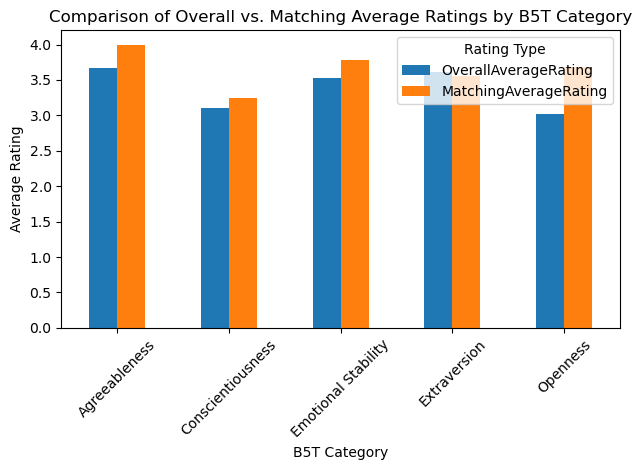

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
grouped_summary.plot(x='CurrentPromptB5T', y=['OverallAverageRating', 'MatchingAverageRating'], kind='bar')
plt.title('Comparison of Overall vs. Matching Average Ratings by B5T Category')
plt.ylabel('Average Rating')
plt.xlabel('B5T Category')
plt.xticks(rotation=45)
plt.legend(title='Rating Type')
plt.tight_layout()
plt.show()


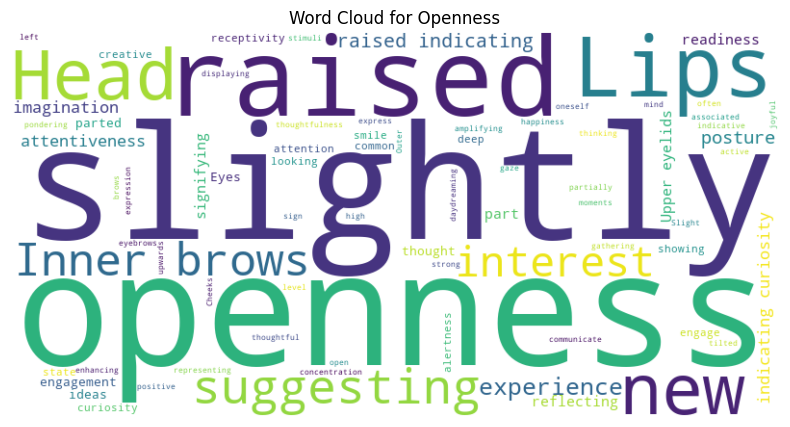

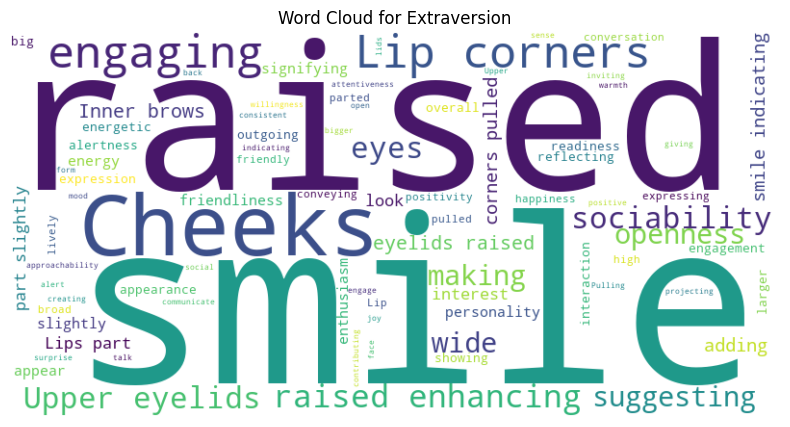

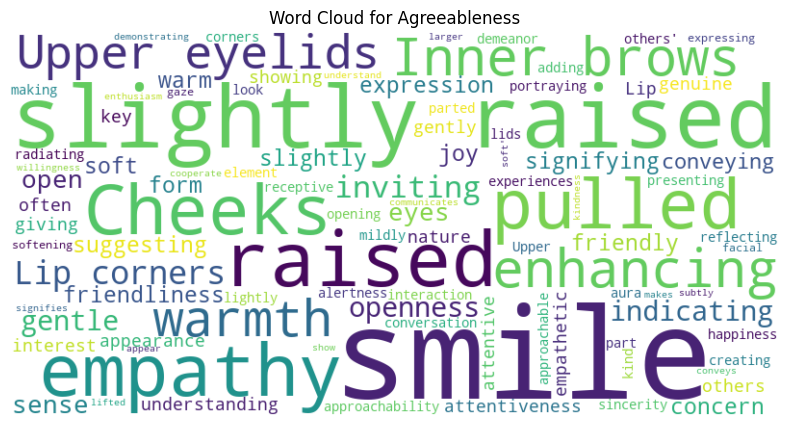

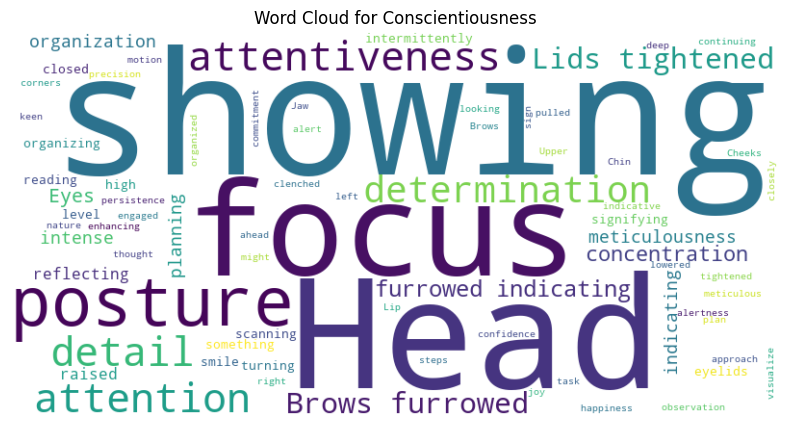

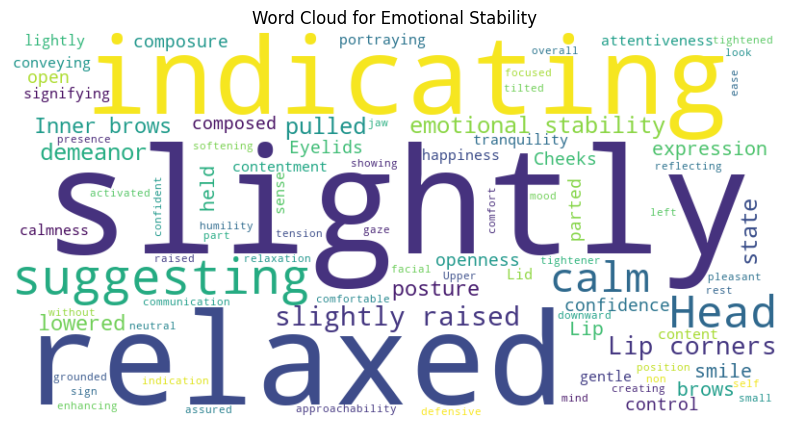

In [5]:
from wordcloud import WordCloud


def fetch_au_descriptions_by_b5t(collection_name):
    collection_ref = db.collection(collection_name)
    docs = collection_ref.stream()

    # Dictionary to hold descriptions aggregated by B5T
    descriptions_by_b5t = {}

    for doc in docs:
        data = doc.to_dict()
        b5t = data.get('currentPromptB5T', '')
        action_units = data.get('actionUnits', {})

        # Initialize description list if new B5T
        if b5t not in descriptions_by_b5t:
            descriptions_by_b5t[b5t] = []

        # Append AU descriptions to the corresponding B5T list
        for au_details in action_units.values():
            if au_details.get('notes'):  # Check if notes/description exists
                descriptions_by_b5t[b5t].append(au_details['notes'])

    return descriptions_by_b5t

descriptions_by_b5t = fetch_au_descriptions_by_b5t('StaticExpressions')

def generate_word_clouds(descriptions_by_b5t):
    for b5t, descriptions in descriptions_by_b5t.items():
        all_descriptions = ' '.join(descriptions)
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_descriptions)

        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Word Cloud for {b5t}')
        plt.axis('off')
        plt.show()

generate_word_clouds(descriptions_by_b5t)


## Comparison of Ratings
Now, let's compare the average matching ratings for each B5T with the overall average ratings.

In [9]:
def fetch_and_process_data(collection_name):
    collection_ref = db.collection(collection_name)
    docs = collection_ref.stream()

    processed_data = []

    # Prepare to calculate averages per B5T globally
    b5t_responses = {}

    for doc in docs:
        doc_data = doc.to_dict()
        currentPromptB5T = doc_data.get('currentPromptB5T', '')
        responses = doc_data.get('responses', {})

        # Prepare lists for overall ratings and for matching B5T ratings
        matching_ratings = []

        for _, details in responses.items():
            b5t = details.get('B5T', '')
            rating = details.get('rating', 0)

            # Collect data for global B5T rating calculations
            if b5t in b5t_responses:
                b5t_responses[b5t].append(rating)
            else:
                b5t_responses[b5t] = [rating]

            # Collect matching ratings
            if b5t == currentPromptB5T:
                matching_ratings.append(rating)

        # Calculate the matching average rating
        if matching_ratings:
            matching_average_rating = sum(matching_ratings) / len(matching_ratings)
        else:
            matching_average_rating = 0

        processed_data.append({
            'DocumentID': doc.id,
            'CurrentPromptB5T': currentPromptB5T,
            'MatchingAverageRating': matching_average_rating
        })

    # Calculate overall average ratings per B5T
    b5t_averages = {b5t: sum(ratings) / len(ratings) for b5t, ratings in b5t_responses.items()}

    return processed_data, b5t_averages

data, b5t_averages = fetch_and_process_data('StaticExpressions')


In [13]:
b5t_averages

{'Emotional Stability': 3.5609756097560976,
 'Conscientiousness': 3.182926829268293,
 'Extraversion': 3.1707317073170733,
 'Openness': 3.6341463414634148,
 'Agreeableness': 3.475609756097561}

In [7]:
import pandas as pd

# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(data)

# Display the data to check structure and initial results
print("Individual Document Matching Ratings:")
print(df.head())

# Create a DataFrame from the B5T averages
b5t_average_df = pd.DataFrame(list(b5t_averages.items()), columns=['B5T', 'OverallB5TAverage'])
print("\nOverall B5T Averages:")
print(b5t_average_df)

# Merging both data for comparison
comparison_df = df.merge(b5t_average_df, left_on='CurrentPromptB5T', right_on='B5T')

# Display the merged data
print("\nComparison of Matching Average Ratings with Overall B5T Ratings:")
print(comparison_df[['DocumentID', 'CurrentPromptB5T', 'MatchingAverageRating', 'OverallB5TAverage']])


Individual Document Matching Ratings:
             DocumentID   CurrentPromptB5T  MatchingAverageRating
0  1DKeINn2nCPuhU3DgqqH           Openness                    4.5
1  51p4xxEJZkfuFQwcuhY3       Extraversion                    2.0
2  5lRokilG4H2o99TYozDI      Agreeableness                    3.5
3  8w5Yv8glxHyZZ9fnECHf  Conscientiousness                    3.5
4  9GLmr1nZv4Zmvv60zWIH           Openness                    2.5

Overall B5T Averages:
                   B5T  OverallB5TAverage
0  Emotional Stability           3.560976
1    Conscientiousness           3.182927
2         Extraversion           3.170732
3             Openness           3.634146
4        Agreeableness           3.475610

Comparison of Matching Average Ratings with Overall B5T Ratings:
              DocumentID     CurrentPromptB5T  MatchingAverageRating  \
0   1DKeINn2nCPuhU3DgqqH             Openness                    4.5   
1   51p4xxEJZkfuFQwcuhY3         Extraversion                    2.0   
2   5lRok

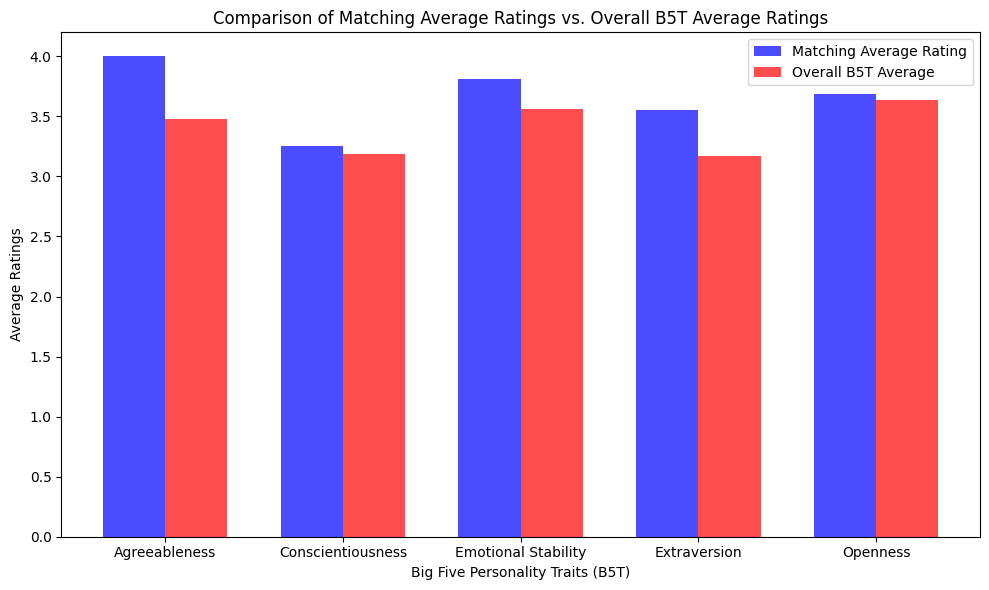

In [13]:
comparison_df = pd.DataFrame(data)  # This should be populated with the matching ratings data
b5t_average_df = pd.DataFrame(list(b5t_averages.items()), columns=['B5T', 'OverallB5TAverage'])

# Merge the individual matching ratings with the overall B5T averages
comparison_df = comparison_df.merge(b5t_average_df, left_on='CurrentPromptB5T', right_on='B5T')

# For better visualization handling, let's group by B5T and calculate the mean for matching averages too, for all records:
grouped_comparison = comparison_df.groupby('B5T').agg({
    'MatchingAverageRating': 'mean',
    'OverallB5TAverage': 'mean'
}).reset_index()

# Setting the positions and width for the bars
positions = list(range(len(grouped_comparison['B5T'])))
width = 0.35  # the width of a bar

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting both bars for each B5T category
plt.bar(positions, grouped_comparison['MatchingAverageRating'], width, label='Matching Average Rating', color='blue', alpha=0.7)
plt.bar([p + width for p in positions], grouped_comparison['OverallB5TAverage'], width, label='Overall B5T Average', color='red', alpha=0.7)

# Adding some aesthetics
plt.xlabel('Big Five Personality Traits (B5T)')
plt.ylabel('Average Ratings')
plt.title('Comparison of Matching Average Ratings vs. Overall B5T Average Ratings')
plt.xticks([p + width / 2 for p in positions], grouped_comparison['B5T'])

# Adding a legend to explain the two bars
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()